# Let's try to predict the Stock Market

In [37]:
import yfinance as yf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [38]:
ticker = "BOVA11.SA"
start_date = "2021-01-01"
today = datetime.now().strftime('%Y-%m-%d')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,115.599998,115.860001,113.580002,114.089996,114.089996,8493213
2021-01-05,114.000000,115.330002,112.330002,114.690002,114.690002,9620565
2021-01-06,114.559998,116.400002,114.339996,114.550003,114.550003,9094234
2021-01-07,114.860001,118.370003,114.860001,118.370003,118.370003,9250545
2021-01-08,118.489998,120.660004,117.720001,120.400002,120.400002,11955320
...,...,...,...,...,...,...
2023-08-16,112.930000,113.730003,111.870003,111.870003,111.870003,8028362
2023-08-17,112.910004,113.040001,111.339996,111.360001,111.360001,9331433
2023-08-18,111.120003,112.169998,110.989998,111.699997,111.699997,8944196


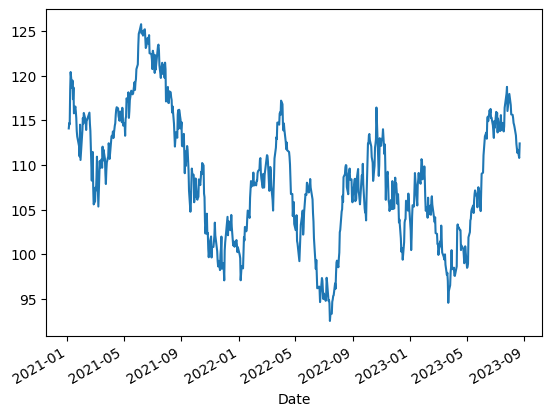

In [39]:
ticker_data = yf.download(ticker, start=start_date, end=today, progress=False)
ticker_data['Adj Close'].plot()
data = pd.DataFrame(ticker_data)
display(data)
prices = data['Close'].values.reshape(-1, 1)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Preparar os dados
X, y = [], []
for i in range(60, len(scaled_prices)):
    X.append(scaled_prices[i-60:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir os dados em treino e teste
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# LSTM

In [40]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
15/15 [==============================] - 5s 64ms/step - loss: 0.1025
Epoch 2/50
15/15 [==============================] - 1s 95ms/step - loss: 0.0160
Epoch 3/50
15/15 [==============================] - 2s 108ms/step - loss: 0.0114
Epoch 4/50
15/15 [==============================] - 1s 69ms/step - loss: 0.0090
Epoch 5/50
15/15 [==============================] - 1s 64ms/step - loss: 0.0080
Epoch 6/50
15/15 [==============================] - 1s 63ms/step - loss: 0.0073
Epoch 7/50
15/15 [==============================] - 1s 62ms/step - loss: 0.0067
Epoch 8/50
15/15 [==============================] - 1s 62ms/step - loss: 0.0063
Epoch 9/50
15/15 [==============================] - 1s 63ms/step - loss: 0.0061
Epoch 10/50
15/15 [==============================] - 1s 63ms/step - loss: 0.0058
Epoch 11/50
15/15 [==============================] - 1s 64ms/step - loss: 0.0056
Epoch 12/50
15/15 [==============================] - 1s 60ms/step - loss: 0.0054
Epoch 13/50
15/15 [=================

4/4 [==============================] - 1s 28ms/step


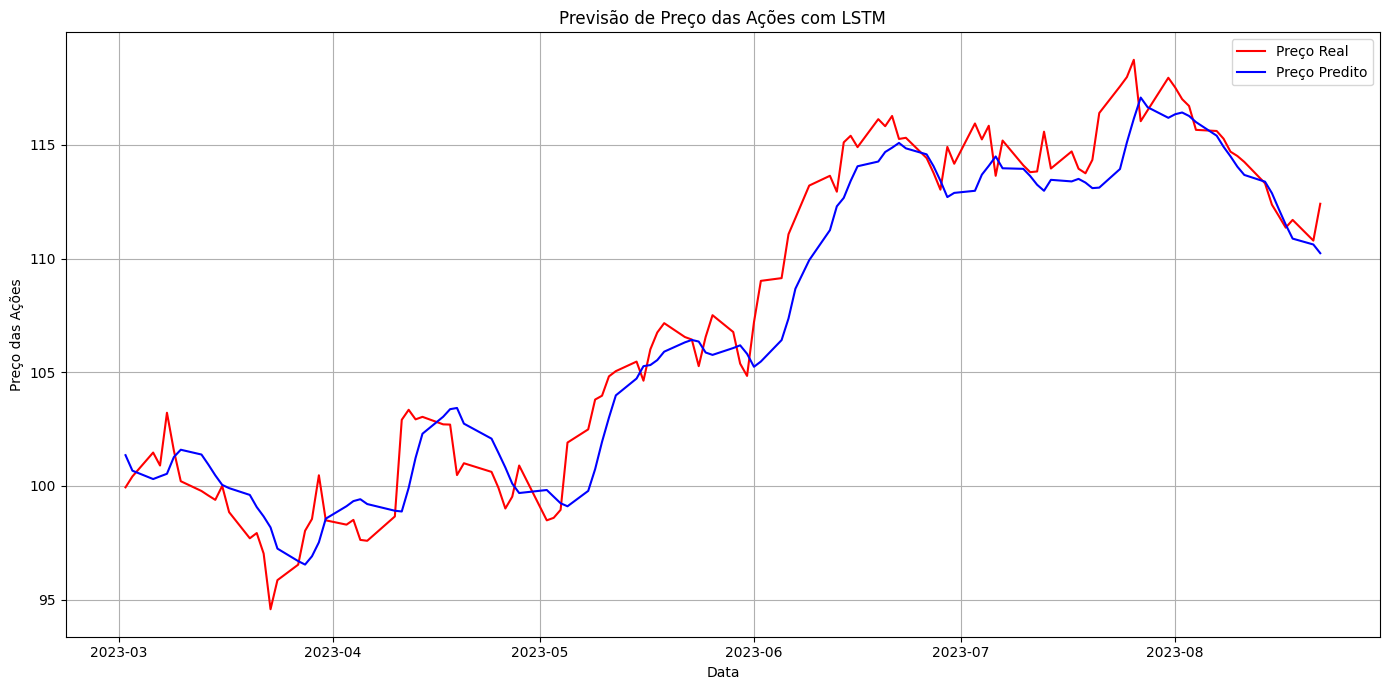

Raiz do Erro Quadrático Médio (RMSE): 106.82


In [41]:

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Obter as datas correspondentes aos preços preditos
dates = data.index[train_size + 60:]

# Plotar os resultados
plt.figure(figsize=(14, 7))
plt.plot(dates, data['Close'][train_size + 60:].values, color='red', label='Preço Real')
plt.plot(dates, predicted_prices, color='blue', label='Preço Predito')
plt.title('Previsão de Preço das Ações com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço das Ações')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")

1/1 [==============================] - 0s 32ms/step


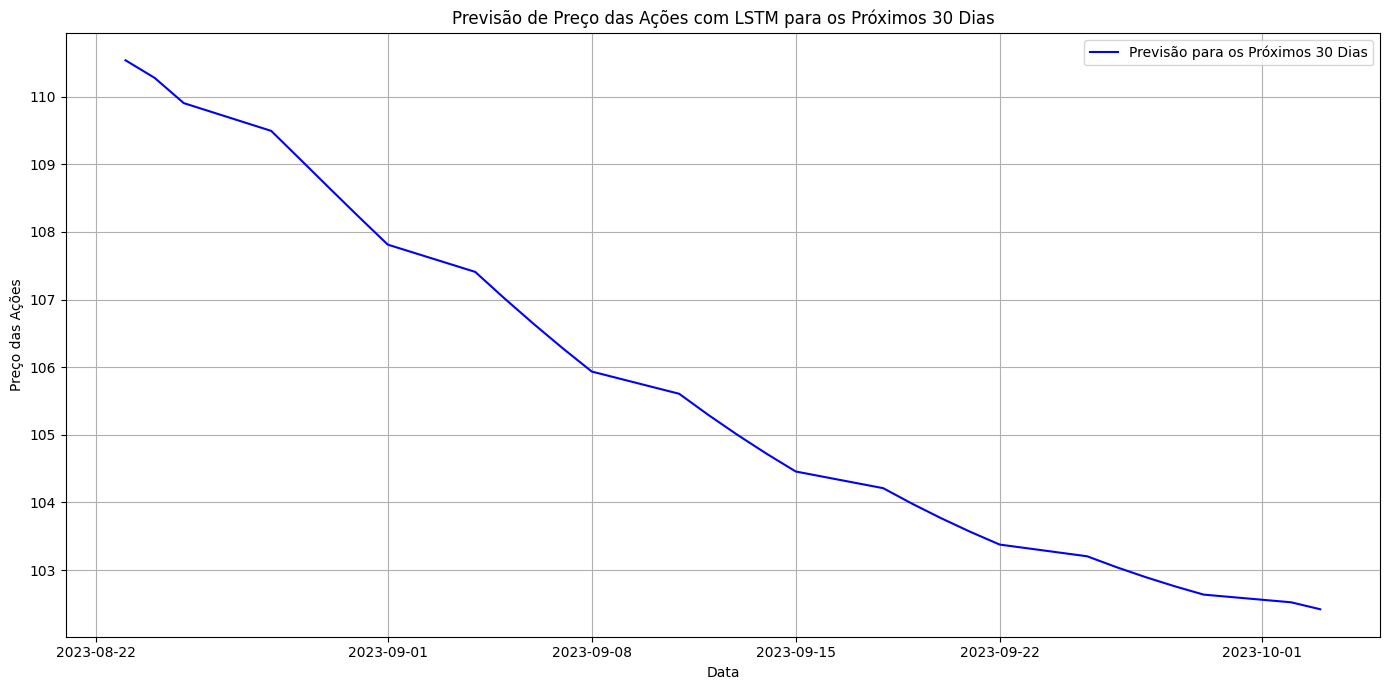

In [42]:
# Obter os últimos 60 dias do conjunto de dados
last_60_days = scaled_prices[-60:]

# Lista para armazenar as previsões
forecast = []

# Prever os próximos 30 dias
for _ in range(30):
    # Fazer a previsão usando o modelo
    next_day = model.predict(last_60_days.reshape(1, 60, 1))
    forecast.append(next_day[0])

    # Atualizar a sequência de entrada
    last_60_days = np.append(last_60_days[1:], next_day, axis=0)

# Desnormalizar as previsões
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Criar datas para os próximos 30 dias
next_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Plotar as previsões
plt.figure(figsize=(14, 7))
plt.plot(next_dates, forecast, color='blue', label='Previsão para os Próximos 30 Dias')
plt.title('Previsão de Preço das Ações com LSTM para os Próximos 30 Dias')
plt.xlabel('Data')
plt.ylabel('Preço das Ações')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()